In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import qiskit
from qiskit import IBMQ, pulse, QuantumCircuit, execute, transpile, Aer, assemble
from qiskit.pulse import library, Schedule, Play, ShiftPhase, DriveChannel
from qiskit.pulse.macros import measure

import qiskit.ignis.verification.randomized_benchmarking as rb
from IPython.display import display

In [2]:
# load IBMQ account and armonk backend
IBMQ.load_account()
armonk_real = IBMQ.providers()[1].backends.ibmq_armonk

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
# import function to modify int_map in the given backend
from functions.backend_modification  import mod_inst_map


In [4]:
# Randomized Benchmarking

# Prepare for RB
# set parameters
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 10

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1, 300, 10)
# nCliffs = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
print(len(nCliffs))

#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0]]

#Do three times as any 1Q Cliffords
length_multiplier = 1

rb_opts = {'length_vector': nCliffs,
           'nseeds': nseeds,
           'rb_pattern': rb_pattern,
           'group_gates': 'Clifford'}

# Create circuits for RB
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

30


In [6]:
# RB with stretch factor
# Since the inst_map in backend change intermediately after modify, we apply multiplier
# instead of original stretch factor
cr_list = [1, 2, 2]
c_list = [cr_list[0]]
for i in range(len(cr_list)-1):
    c_list.append(cr_list[i]*cr_list[i+1])
print('Stretch factor is ', c_list)


Stretch factor is  [1, 2, 4]


Cj =  1
Original Parameters
[{'duration': 640, 'amp': (0.010830930884787173+0.31802263121405466j), 'sigma': 160, 'beta': -4.526603848023497}]
Modified Parameters
[{'duration': 640, 'amp': (0.010830930884787173+0.31802263121405466j), 'sigma': 160, 'beta': -4.526603848023497}]
Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.998020, EPC: 0.000990
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.998815, EPC: 0.000592
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.998043, EPC: 0.000979
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.997974, EPC: 0.001013
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.998416, EPC: 0.000792
Compiling seed 5
Simulating seed 5
After seed 5, alpha: 0.997677, EPC: 0.001162
Compiling seed 6
Simulating seed 6
After seed 6, alpha: 0.997997, EPC: 0.001002
Compiling seed 7
Simulating seed 7
After seed 7, alpha: 0.998317, EPC: 0.000841
Compiling seed 8
Simulating seed 8
After seed 8, alpha: 0.998504, EPC: 0.000748
Comp

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/compiler/ass

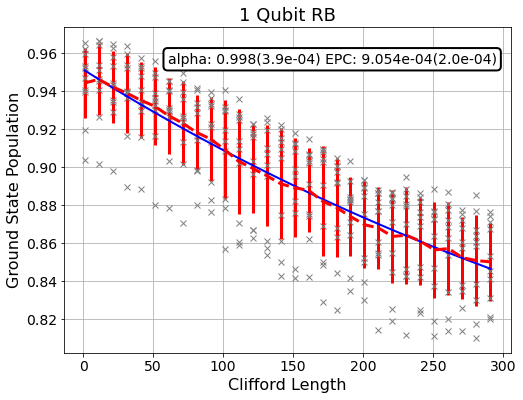

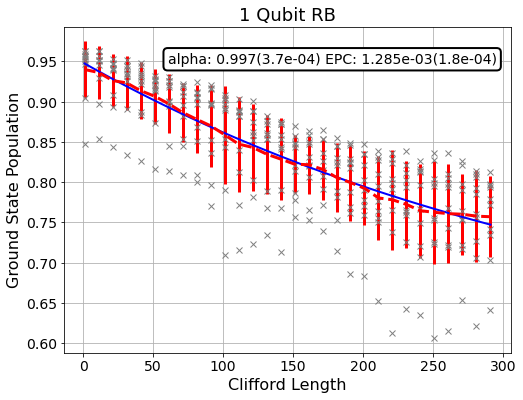

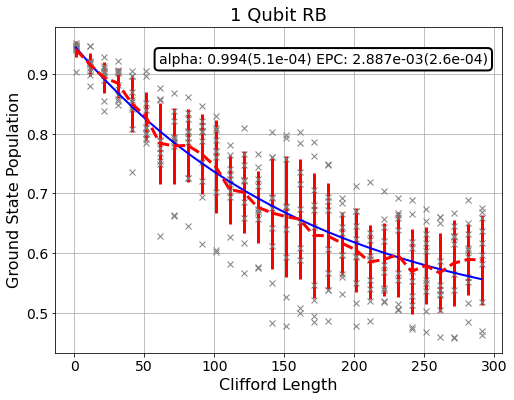

In [7]:
shots = 4096

# list store something helpful
transpiled_circs_list = []
rb_schedules_list = []
qobj_list = []
ydata = []
Fitter_list = []

for ci in cr_list:
    print('Cj = ', c_list[cr_list.index(ci)])
    # Apply the stretch factor into backend (modify inst_map of the backend)
    inst_map = armonk_real.defaults().instruction_schedule_map
    qubits = [0]
    dri_list = [DriveChannel(0)]
    mod_inst_map(inst_map, ci, qubits, dri_list)
    ydata_temp = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])

    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)

        # transpile circuit into the basis gate set of the backend
        transpiled_rb_circ_seed = qiskit.transpile(rb_circ_seed,
                                                   armonk_real,
                                                   initial_layout=[0],
                                                   basis_gates=armonk_real.configuration().basis_gates
                                                   )
        # store the transpiled circuits if need
        for i in range(nseeds):
            transpiled_circs_list.append(transpiled_rb_circ_seed[i])

        print('Simulating seed %d'%rb_seed)

        # # translate circuits into pulse through the inst_map in the backend
        # # (we have already modify the inst_map of the backend)
        rb_schedules = qiskit.schedule(transpiled_rb_circ_seed,
                                       armonk_real)
        # store the pulse schedules if need
        rb_schedules_list.append(rb_schedules)

        # combine the pulse schedules as an assemble
        rb_qobj = assemble(rb_schedules,
                           backend=armonk_real,
                           meas_level=2,
                           meas_return='avg',
                           shots=shots,
                           qubit_lo_freq=armonk_real.defaults().qubit_freq_est,
                           meas_lo_freq=armonk_real.defaults().meas_freq_est,
                           rep_time=armonk_real.configuration().rep_times)

        # store the rb_qobj if need
        qobj_list.append(rb_qobj)

        # implement the assemble on backend
        real_job = armonk_real.run(rb_qobj)

        # get the result of job
        rb_result = real_job.result()

        # Add mitigated data to the RB fitter
        rb_fit.add_data(rb_result)

        print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        ydata_temp.append(rb_fit.ydata[0]['mean'])

    # plot data for each stretch factor c
    plt.figure(figsize=(8, 6), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    # Plot the essence by calling plot_rb_data
    rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    # Add title and label
    ax.set_title('%d Qubit RB'%(nQ), fontsize=18)
    plt.show()

    # add data to the list
    ydata.append(ydata_temp)
    Fitter_list.append(rb_fit)

print('Finished running RB')

In [28]:
# Calculate the gamma constant for Richardson Extrapolation

def gamma_j(c_list_):
    gamma_list = []
    for j in range(len(c_list_)):
        gamma_temp = 1
        for m_a in range(j):
            gamma_temp *= c_list_[m_a]/(c_list_[j]-c_list_[m_a])
        for m_b in range(len(c_list_)-j-1):
            gamma_temp *= c_list_[m_b+j+1]/(c_list_[j]-c_list_[m_b+j+1])
        gamma_list.append(gamma_temp)
    if len(c_list_)%2==0:
        gamma = np.array(gamma_list)*(-1)
    else:
        gamma = np.array(gamma_list)
    return gamma

# gamma_1 with first two stretch factors and gamma_2 calculate from first 3 stretch factors.


gamma_list = [gamma_j(c_list[0:2]), gamma_j(c_list[0:3])]
for i in range(2):
    print('gamma_', i+1)
    print('c = ', c_list[0:2+i])
    print('gamma_1 = ', gamma_list[i])
    # Check the constant didn't obey the constraint
    # (Summation of gamma_j = 1)
    # (Summation of gamma_j * c_j**k (k from 1 to n) = 0)
    print('check constraints')
    print('j from 0 to n = ', len(c_list[0:2+i])-1)
    print('Summation of gamma_j = ',sum(gamma_list[i]))
    rc = 0
    for j in range(len(c_list[0:2+i])-1):
        for k in range(len(gamma_list[i])):
            rc += c_list[0:2+i][k]**(j+1)*gamma_list[i][k]
    print('Summation of gamma_j * c_j**(from 1 to n) = ', rc)

gamma_ 1
c =  [1, 2]
gamma_1 =  [ 2. -1.]
check constraints
j from 0 to n =  1
Summation of gamma_j =  1.0
Summation of gamma_j * c_j**(from 1 to n) =  0.0
gamma_ 2
c =  [1, 2, 4]
gamma_1 =  [ 2.66666667 -2.          0.33333333]
check constraints
j from 0 to n =  2
Summation of gamma_j =  0.9999999999999998
Summation of gamma_j * c_j**(from 1 to n) =  -8.881784197001252e-16


In [29]:
# calculate extrapolation result
ext_data = np.zeros([2, len(ydata[0][-1])])
for i in range(len(ext_data)):
    for j in range(len(ext_data[i])):
        ext_temp = 0
        for k in range(len(c_list[0:2+i])):
            ext_temp += gamma_list[i][k]*ydata[k][-1][j]
        ext_data[i][j] = ext_temp
# print(ext_data)

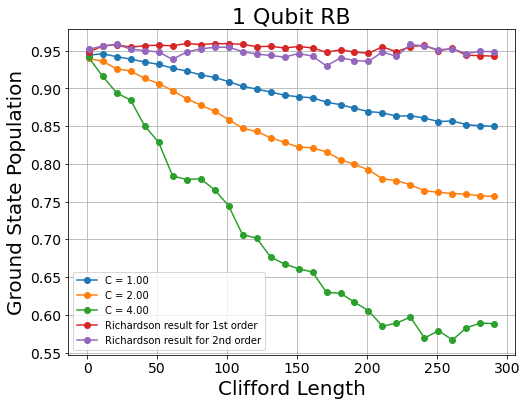

In [45]:
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('%d Qubit RB'%(nQ), fontsize=22)
plt.xlabel('Clifford Length', fontsize=20)
plt.ylabel('Ground State Population', fontsize=20)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.grid()
for i in range(len(c_list)):
    plt.plot(xdata[0], ydata[i][-1], '-o', label='C = %.2f'%c_list[i])

plt.plot(xdata[0], ext_data[0], '-o', label = 'Richardson result for 1st order')
plt.plot(xdata[0], ext_data[1], '-o', label = 'Richardson result for 2nd order')
plt.legend()
# plt.savefig('Richardson_RB.svg', transparent=True)

plt.show()